# Chapter 9 - Support Vector Machines

In [44]:
import warnings
warnings.filterwarnings('ignore')

- [Lab: 9.6.1 Support Vector Classifier](#9.6.1-Support-Vector-Classifier)
- [Lab: 9.6.2 Support Vector Machine](#9.6.2-Support-Vector-Machine)
- [Lab: 9.6.3 ROC Curves](#9.6.3-ROC-Curves)
- [Lab: 9.6.4 SVM with Multiple Classes](#9.6.4-SVM-with-Multiple-Classes)
- [Lab: 9.6.5 Application to Gene Expression Data](#9.6.5-Application-to-Gene-Expression-Data)

In [45]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

%matplotlib inline
sns.set_theme()
sns.set_style("ticks")
# plt.style.use('seaborn-white')

## LAB

### 9.6.1 Support Vector Classifier

Define a function to plot a classifier with support vectors.

In [46]:
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
    # Support vectors indicated in plot by vertical lines
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='|', s=100, linewidths=1)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

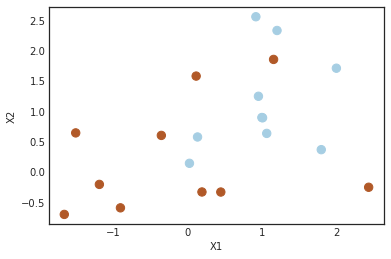

In [47]:
# Generating random data: 20 observations of 2 features and divide into two classes.
np.random.seed(5)
X = np.random.randn(20,2)
y = np.repeat([1,-1], 10)

X[y == -1] = X[y == -1] +1
plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2');

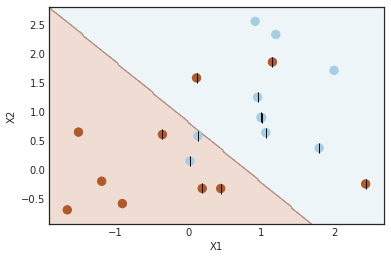

Number of support vectors:  13


In [48]:
# Support Vector Classifier with linear kernel.
svc = SVC(C= 1.0, kernel='linear')
svc.fit(X, y)

plot_svc(svc, X, y)

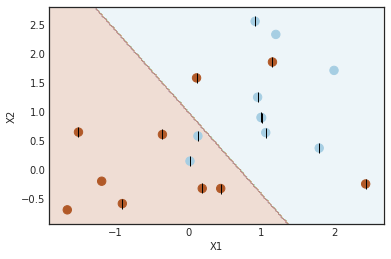

Number of support vectors:  16


In [49]:
# When using a smaller cost parameter (C=0.1) the margin is wider, resulting in more support vectors.
svc2 = SVC(C=0.1, kernel='linear')
svc2.fit(X, y)
plot_svc(svc2, X, y)

In [50]:
# Select the optimal C parameter by cross-validation
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}]
clf = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=10, scoring='accuracy', return_train_score=True)
clf.fit(X, y)
clf.cv_results_

{'mean_fit_time': array([0.00066106, 0.00050704, 0.00057607, 0.00051739, 0.00052857,
        0.00054688, 0.00071185]),
 'std_fit_time': array([1.79794865e-04, 2.10003464e-05, 4.42281309e-05, 2.88343493e-05,
        2.98749040e-05, 2.58419345e-05, 7.95007851e-05]),
 'mean_score_time': array([0.00044382, 0.00039086, 0.00039573, 0.00036874, 0.00035818,
        0.00037916, 0.00037329]),
 'std_score_time': array([8.73090822e-05, 5.21050373e-05, 4.14900119e-05, 3.50452928e-05,
        2.25924847e-05, 2.51711876e-05, 1.83083271e-05]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 5, 10, 100],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 5},
  {'C': 10},
  {'C': 100}],
 'split0_test_score': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
 'split1_test_score': array([0.5, 0.5, 0.5, 0. , 0. , 0. , 0. ]),
 'split2_test_score': array([0.5, 0.5, 0

In [51]:
# 0.001 is best according to GridSearchCV. 
clf.best_params_

{'C': 0.001}

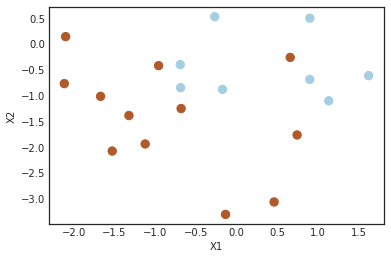

In [52]:
# Generating test data
np.random.seed(1)
X_test = np.random.randn(20,2)
y_test = np.random.choice([-1,1], 20)
X_test[y_test == 1] = X_test[y_test == 1] -1

plt.scatter(X_test[:,0], X_test[:,1], s=70, c=y_test, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2');

In [53]:
# svc2 : C = 0.1
y_pred = svc2.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred),index=svc.classes_, columns=svc.classes_)

,-1,1
-1,2,6
1,0,12


In [54]:
svc3 = SVC(C=0.001, kernel='linear')
svc3.fit(X, y)

# svc3 : C = 0.001
y_pred = svc3.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred), index=svc3.classes_, columns=svc3.classes_)
# The misclassification is the same

,-1,1
-1,2,6
1,0,12


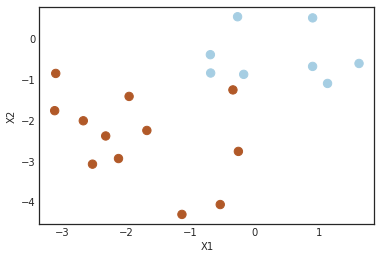

In [55]:
# Changing the test data so that the classes are really seperable with a hyperplane.
X_test[y_test == 1] = X_test[y_test == 1] -1
plt.scatter(X_test[:,0], X_test[:,1], s=70, c=y_test, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2');

In [56]:
svc4 = SVC(C=10.0, kernel='linear')
svc4.fit(X_test, y_test)

SVC(C=10.0, kernel='linear')

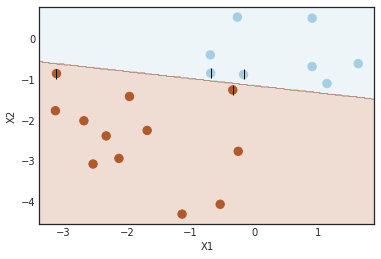

Number of support vectors:  4


In [57]:
plot_svc(svc4, X_test, y_test)

In [58]:
# Increase the margin. Now there is one misclassification: increased bias, lower variance.
svc5 = SVC(C=1, kernel='linear')
svc5.fit(X_test, y_test)

SVC(C=1, kernel='linear')

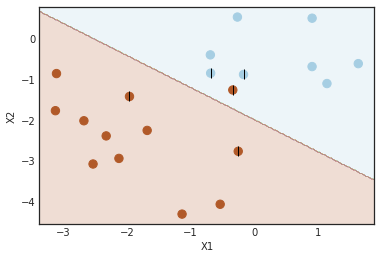

Number of support vectors:  5


In [59]:
plot_svc(svc5, X_test, y_test)

### 9.6.2 Support Vector Machine 

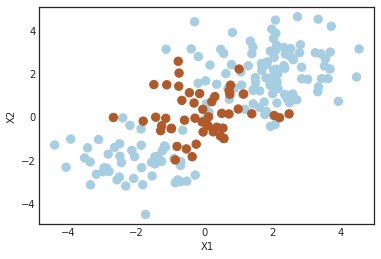

In [60]:
# Generating test data
np.random.seed(8)
X = np.random.randn(200,2)
X[:100] = X[:100] +2
X[101:150] = X[101:150] -2
y = np.concatenate([np.repeat(-1, 150), np.repeat(1,50)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2');

In [61]:
svm = SVC(C=1.0, kernel='rbf', gamma=1)
svm.fit(X_train, y_train)

SVC(gamma=1)

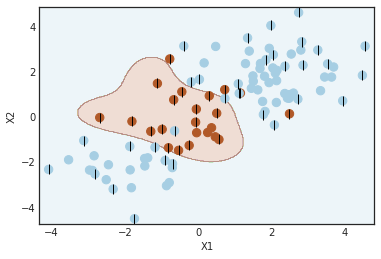

Number of support vectors:  51


In [62]:
plot_svc(svm, X_train, y_train)

In [63]:
# Increasing C parameter, allowing more flexibility
svm2 = SVC(C=100, kernel='rbf', gamma=1.0)
svm2.fit(X_train, y_train)

SVC(C=100, gamma=1.0)

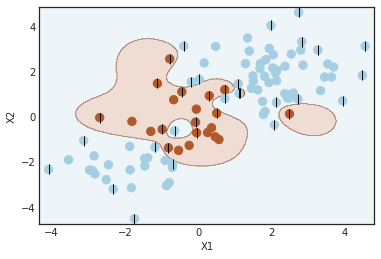

Number of support vectors:  36


In [64]:
plot_svc(svm2, X_train, y_train)

In [65]:
# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100],
                     'gamma': [0.5, 1,2,3,4]}]
clf = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, cv=10, scoring='accuracy', return_train_score=True)
clf.fit(X_train, y_train)
clf.cv_results_

{'mean_fit_time': array([0.00106685, 0.0010143 , 0.00093646, 0.0010546 , 0.00105991,
        0.00085523, 0.00093763, 0.00108764, 0.00115786, 0.00118222,
        0.00080123, 0.00087333, 0.00106106, 0.0011728 , 0.00116882,
        0.00075266, 0.00079341, 0.00117173, 0.00128505, 0.0013114 ,
        0.00083828, 0.00093329, 0.00118268, 0.00129588, 0.00120955]),
 'std_fit_time': array([3.59397658e-04, 2.70819097e-04, 7.91113515e-05, 3.24116094e-05,
        1.63823927e-05, 2.67263824e-05, 1.88393075e-05, 2.51285604e-05,
        7.18725214e-05, 2.54325022e-05, 3.64486102e-05, 5.61982481e-05,
        1.09666441e-04, 7.81568286e-05, 1.21887459e-04, 7.87144238e-05,
        5.92069519e-05, 8.58881017e-05, 6.79264072e-05, 7.68389606e-05,
        3.88882556e-05, 5.51694874e-05, 7.44938269e-05, 4.80261724e-05,
        1.15978756e-04]),
 'mean_score_time': array([0.00052166, 0.00053229, 0.00038953, 0.00045094, 0.00044553,
        0.00042875, 0.00043483, 0.00043859, 0.00043933, 0.00044641,
        0.00

In [66]:
clf.best_params_

{'C': 10, 'gamma': 0.5}

In [67]:
confusion_matrix(y_test, clf.best_estimator_.predict(X_test))

array([[66,  7],
       [ 6, 21]])

In [68]:
# 15% of test observations misclassified
clf.best_estimator_.score(X_test, y_test)

0.87

### 9.6.3 ROC Curves

Comparing the ROC curves of two models on train/test data. One model is more flexible than the other.

In [69]:
svm3 = SVC(C=1, kernel='rbf', gamma=2)
svm3.fit(X_train, y_train)

SVC(C=1, gamma=2)

In [70]:
# More flexible model
svm4 = SVC(C=1, kernel='rbf', gamma=50)
svm4.fit(X_train, y_train)

SVC(C=1, gamma=50)

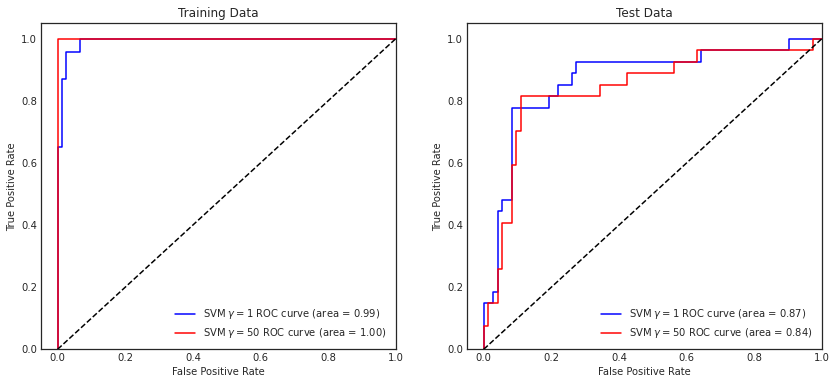

In [71]:
y_train_score3 = svm3.decision_function(X_train)
y_train_score4 = svm4.decision_function(X_train)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_train, y_train_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_train, y_train_score4)
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(false_pos_rate3, true_pos_rate3, label='SVM $\gamma = 1$ ROC curve (area = %0.2f)' % roc_auc3, color='b')
ax1.plot(false_pos_rate4, true_pos_rate4, label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, color='r')
ax1.set_title('Training Data')

y_test_score3 = svm3.decision_function(X_test)
y_test_score4 = svm4.decision_function(X_test)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_test, y_test_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_test, y_test_score4)
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

ax2.plot(false_pos_rate3, true_pos_rate3, label='SVM $\gamma = 1$ ROC curve (area = %0.2f)' % roc_auc3, color='b')
ax2.plot(false_pos_rate4, true_pos_rate4, label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, color='r')
ax2.set_title('Test Data')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

As expected, the more flexible model scores better on training data but worse on the test data.

### 9.6.4 SVM with Multiple Classes

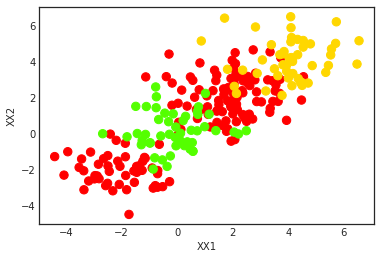

In [72]:
# Adding a third class of observations
np.random.seed(8)
XX = np.vstack([X, np.random.randn(50,2)])
yy = np.hstack([y, np.repeat(0,50)])
XX[yy ==0] = XX[yy == 0] +4

plt.scatter(XX[:,0], XX[:,1], s=70, c=yy, cmap=plt.cm.prism)
plt.xlabel('XX1')
plt.ylabel('XX2');

In [73]:
svm5 = SVC(C=1, kernel='rbf')
svm5.fit(XX, yy)

SVC(C=1)

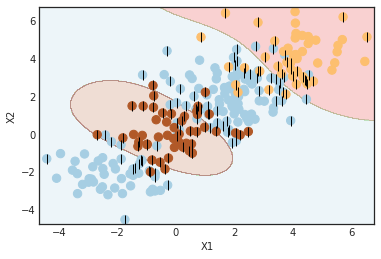

Number of support vectors:  128


In [74]:
plot_svc(svm5, XX, yy)

### 9.6.5 Application to Gene Expression Data

In R, I exported the dataset from package 'ISLR' to csv files.

In [75]:
X_train = pd.read_csv('Data/Khan_xtrain.csv').drop('Unnamed: 0', axis=1)
y_train = pd.read_csv('Data/Khan_ytrain.csv').drop('Unnamed: 0', axis=1).values.ravel()
X_test = pd.read_csv('Data/Khan_xtest.csv').drop('Unnamed: 0', axis=1)
y_test = pd.read_csv('Data/Khan_ytest.csv').drop('Unnamed: 0', axis=1).values.ravel()

In [76]:
# y_train counts
pd.Series(y_train).value_counts(sort=False)

2    23
4    20
3    12
1     8
dtype: int64

In [77]:
# y_test counts
pd.Series(y_test).value_counts(sort=False)

3    6
2    6
4    5
1    3
dtype: int64

In [78]:
# This model gives identical results to the svm() of the R package e1071, also based on libsvm library.
svc = SVC(kernel='linear')

# This model is based on liblinear library and gives 100 score on the test data. 
#svc = LinearSVC()

svc.fit(X_train, y_train)

SVC(kernel='linear')

In [79]:
cm = confusion_matrix(y_train, svc.predict(X_train))
cm_df = pd.DataFrame(cm.T, index=svc.classes_, columns=svc.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True       1   2   3   4
Predicted               
1          8   0   0   0
2          0  23   0   0
3          0   0  12   0
4          0   0   0  20


In [80]:
cm = confusion_matrix(y_test, svc.predict(X_test))
cm_df = pd.DataFrame(cm.T, index=svc.classes_, columns=svc.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True       1  2  3  4
Predicted            
1          3  0  0  0
2          0  6  2  0
3          0  0  4  0
4          0  0  0  5
